In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import train_test_split

## Loading in the Data 
The csv loaded below contains many major US companies and the diversity of each company. In addition, we manually attached the Fortune500 "Best Places to Work" Rank of each company. If a company was listed on the Fortune500 list of the 500 best places to work, we inputted their rank in a new column before loading the csv into this notebook.

In [22]:
employee_diversity = pd.read_csv("top22.csv")

If a companies's Fortune Rank value was n/a, it means that the company did not show up on the list of best places to work. As such, we change all of those n/a values to zero to reflect that they did not make the list.

In [23]:
employee_diversity = employee_diversity.rename(columns={" Fortune_Rank":"Fortune_Rank", " % White ":"%White", 
                                                       " % Asian ":"%Asian", " % Latino ":"%Latino", 
                                                       " % Black ":"%Black", " % Multi ":"%Multi", 
                                                       " % Other ":"%Other", " Male % ":"Male%", 
                                                       " Female % ":"Female%"})
employee_diversity["Fortune_Rank"] = employee_diversity["Fortune_Rank"].fillna(0)
employee_diversity.head()

,Date,Type,Company,Female%,Male%,%White,%Asian,%Latino,%Black,%Multi,%Other,Fortune_Rank
0,2014,Country,U.S. Population,50.79,49.21,64.0,4.0,16.0,12.0,1.0,3.00,0.0
1,2014,Social Media,Facebook,31.00,69.00,57.0,34.0,4.0,2.0,3.0,-,168.0
2,2014,Social Media,Instagram,31.00,69.00,57.0,34.0,4.0,2.0,3.0,-,0.0
3,2014,Social Media,Google+,30.00,70.00,61.0,30.0,3.0,2.0,4.0,NaN,0.0
4,2014,Social Media,YouTube,30.00,70.00,61.0,30.0,3.0,2.0,4.0,NaN,0.0


## Cleaning and Preparing the Data

In the code below, the following tasks are accomplished in order to ensure model accuracy:
    1. since many of the companies are featured for several years, the dataset is cut down to only the May2018 diversity statistics.                                                         2.The Fortune500 ranks are set to 0 if a company did not make the list, or 1 if the company did make the list. We decided that the difference between being ranked 11 or 111, for example, was not worth testing for. Instead, we decided to just see how valuable being diverse was in being included on the fortune500 list at all.

In [24]:
employee_diversity["Fortune_Rank"] = employee_diversity["Fortune_Rank"].astype(int)
employee_diversity.head()

,Date,Type,Company,Female%,Male%,%White,%Asian,%Latino,%Black,%Multi,%Other,Fortune_Rank
0,2014,Country,U.S. Population,50.79,49.21,64.0,4.0,16.0,12.0,1.0,3.00,0
1,2014,Social Media,Facebook,31.00,69.00,57.0,34.0,4.0,2.0,3.0,-,168
2,2014,Social Media,Instagram,31.00,69.00,57.0,34.0,4.0,2.0,3.0,-,0
3,2014,Social Media,Google+,30.00,70.00,61.0,30.0,3.0,2.0,4.0,NaN,0
4,2014,Social Media,YouTube,30.00,70.00,61.0,30.0,3.0,2.0,4.0,NaN,0


In [25]:
#cut off dataset starting at the 2018 rows
employee_diversity = employee_diversity.iloc[128:,]
employee_diversity.head()

,Date,Type,Company,Female%,Male%,%White,%Asian,%Latino,%Black,%Multi,%Other,Fortune_Rank
128,May 2018,Social Media,Facebook,35.0,65.0,49.0,40.0,5.0,3.0,3.0,1.00,168
129,May 2018,Social Media,Instagram,35.0,65.0,49.0,40.0,5.0,3.0,3.0,1.00,0
130,May 2018,Social Media,Google+,31.0,69.0,56.0,35.0,4.0,2.0,4.0,1.00,0
131,May 2018,Social Media,YouTube,31.0,69.0,56.0,35.0,4.0,2.0,4.0,1.00,0
132,May 2018,Social Media,LinkedIn,42.0,58.0,52.0,39.0,4.0,4.0,2.0,-,0


In [26]:
employee_diversity["Fortune_Rank"].values[employee_diversity["Fortune_Rank"]>0] = 1
employee_diversity.head()

,Date,Type,Company,Female%,Male%,%White,%Asian,%Latino,%Black,%Multi,%Other,Fortune_Rank
128,May 2018,Social Media,Facebook,35.0,65.0,49.0,40.0,5.0,3.0,3.0,1.00,1
129,May 2018,Social Media,Instagram,35.0,65.0,49.0,40.0,5.0,3.0,3.0,1.00,0
130,May 2018,Social Media,Google+,31.0,69.0,56.0,35.0,4.0,2.0,4.0,1.00,0
131,May 2018,Social Media,YouTube,31.0,69.0,56.0,35.0,4.0,2.0,4.0,1.00,0
132,May 2018,Social Media,LinkedIn,42.0,58.0,52.0,39.0,4.0,4.0,2.0,-,0


In [27]:
columns_to_use = ["Male%", "%White"]
diversity_data = employee_diversity[columns_to_use]

In [28]:
#Perform the train test split
train_x, test_x, train_y, test_y = train_test_split(diversity_data, employee_diversity["Fortune_Rank"], test_size=0.20, random_state=100)



## Model One
For the first model, we tried to use Linear Regression to try to predict if a company was on the Fortune500 based on their diversity. We utilized the %white column as our main variable, in hopes that lower percentage of white employees would lead to more companies being on the Fortune500 list. The model showed very inconclusive results (as shown in the graph below), so we decided to create another model.

In [29]:
def rmse(actual_y, predicted_y):
    '''
    Args:
        actual_y: the actual y column of our data frame
        predicted_y: the y values our model predicted
    
    Returns:
        the root mean squared error between our predicted and actual
    '''
    return np.sqrt(np.mean(((actual_y - predicted_y)**2)))


def cross_validate_rmse(model, X, y):
    '''
    Args:
        model: the model we are using to predict
        X: the X values we are using to predict 
        y: the actual Y values we are trying to estimate
        
    Returns:
        Performs a 5 Fold cross validation, and computes the mean RMSE of the values. Computes the cross val error. 
    '''
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

In [30]:
model = LinearRegression()
model.fit(train_x, train_y)
prediction = model.predict(train_x)

In [31]:
train_error1 = rmse(train_y, prediction)
train_error1

0.4425205738081768

In [32]:
cv_error1 = cross_validate_rmse(model, train_x, train_y)
cv_error1

0.5772873847905837

In [33]:
prediction

array([ 0.0149838 ,  0.68662988,  0.54157866,  0.54157866,  0.52646465,
        0.48008958,  0.66527145,  0.5161233 ,  0.3697595 ,  0.41386376,
        0.24097456,  0.40390307,  0.38964616,  0.19634827, -0.16836896,
        0.72651991,  0.47038506,  0.5085663 ,  0.21225831,  0.54555527,
        0.98226213,  0.15896307,  0.59407785,  0.54157866,  0.5085663 ,
        0.39629089,  0.53612991])

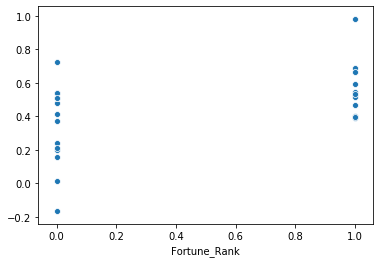

In [14]:
sns.scatterplot(x=train_y, y=prediction)

## Model 2
Because our Y variable (whether or not a company is on the Fortune500 list) is binary, we decided to creat a logistic regression model instead of a linear regression model in hopes of revealing a more defined trend. This is because logistic regression is better at predicting categorical variables. Outside of one company with an outlier of over 70% white employees, the logistic regression graph below clearly indicates that diverse companies are the ones found on the Fortune500 list.

In [34]:
model2 = LogisticRegression(solver="lbfgs")
model2.fit(diversity_data, employee_diversity["Fortune_Rank"])
prediction2 = model2.predict(diversity_data)

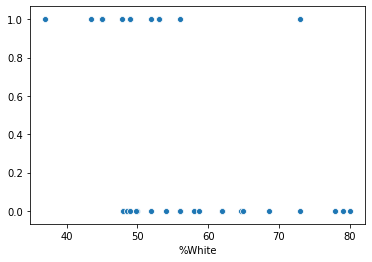

In [89]:
sns.scatterplot(x=diversity_data["%White"], y=prediction2)

## Conclusion

After cleaning the data and merging it with a column showing whether or not a company is one the Fortune500 list, it can be safely concluded that the Fortune500 list consists mainly of diverse companies. This provides incentive for Tesla to diversify as well, and also proves that working in an open, diverse, and encouraging environment produces positive results and positive publicity.